# Example code

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import tqdm
from scipy.special import erf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.style.use('ggplot')

In [2]:
# functions for link estimation
def integrand(t,x,hh,tau2):
    return np.cos(t*x)*(1-t**2)**3 * np.exp((tau2 *t**2)/(2* hh**2))/np.pi
def K1(x,hh,tau2):
    arr = np.zeros(len(x))
    points = np.linspace(0,1,1001)
    for i in range(len(x)):
        arr[i] = sum(integrand(points,x[i],hh,tau2))/1000
    return arr
def NW(xx,w,yy,hh,tau2):
    """
    xx (array) : input of the function to be predicted
    w (array), yy (array) : n pairs of observations
    hh (float) : bandwidth
    tau2 (float) : variance of the errors in input variables
    """
    arr = np.zeros(len(xx))
    for i in tqdm.tqdm(range(len(xx))): #O(input array)
        inp = (xx[i]-w)/hh
        KK = K1(inp,hh,tau2)
        arr[i] = yy@KK/sum(KK)
    return arr
def rearrangement(x, prediction, nn):
    nx    = (x - min(x)) / (max(x) - min(x)) 
    uus = np.arange(0,nn+1,1) / nn
    rfus  = np.interp(uus,nx,prediction) 		
    return np.quantile(rfus, nx)

### Data Generation

In [3]:
seed = 0
n = 1500 # sample size
p = 200 # dimension of coefficient
X = st.norm.rvs(size=(n,p),random_state=int(seed)) # design matrix
beta_true = np.append(np.ones(100),np.zeros(p-100)) 
beta_true = beta_true / np.sqrt(beta_true@beta_true) # coefficient satisfying an identifiabity condition
def link(t): # link function
    return erf(t) + 1
y = link(X@beta_true) + st.norm.rvs(size=n,random_state=int(seed))/3 # response involving Gaussian noise

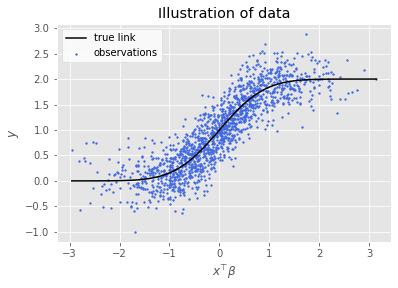

In [4]:
xx = np.linspace(min(X@beta_true),max(X@beta_true),100)
plt.plot(xx, link(xx), label="true link", color="black");
plt.scatter(X@beta_true, y, label="observations", color="RoyalBlue", s=3);
plt.legend(facecolor="white"); plt.title("Illustration of data"); 
plt.xlabel(r"$x^\top\beta$"); plt.ylabel("$y$");

### Pilot estimation and its adjustment

In [5]:
# pilot estimation 
beta_tilde = np.linalg.inv(X.T@X)@X.T@y # lesat squares estimate

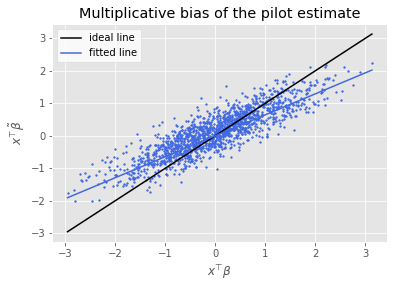

In [6]:
plt.plot(xx, xx, label="ideal line", color="black");
plt.scatter(X@beta_true, X@beta_tilde,  color="RoyalBlue", s=3);
plt.plot(xx, xx*(beta_true@beta_tilde), label="fitted line", color="RoyalBlue");
plt.legend(facecolor="white"); plt.title("Multiplicative bias of the pilot estimate"); 
plt.xlabel(r"$x^\top\beta$"); plt.ylabel(r"$x^\top\tilde\beta$");

In [7]:
# observable adjustment for the pilot estimate
df_hat = p
v_hat = 1-df_hat/n
r_hat = np.mean((y-X@beta_tilde)**2)**(1/2)
gamma_hat = 1/v_hat -1
a_hat2 = (X@beta_tilde)@(X@beta_tilde)/n -p/n *(1- p/n)*r_hat**2 /v_hat**2
a_hat = np.sqrt(a_hat2)
sigma_hat2 = p/n *(r_hat/v_hat)**2
W = (X@beta_tilde + gamma_hat*((X@beta_tilde)-y))/a_hat

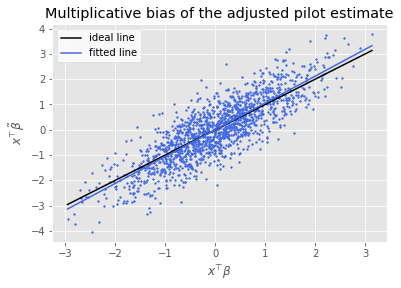

In [8]:
plt.plot(xx, xx, label="ideal line", color="black");
plt.scatter(X@beta_true, W,  color="RoyalBlue", s=3);
plt.plot(xx, xx*((X@beta_true)@W)/((X@beta_true)@(X@beta_true)), label="fitted line", color="RoyalBlue");
plt.legend(facecolor="white"); plt.title("Multiplicative bias of the adjusted pilot estimate"); 
plt.xlabel(r"$x^\top\beta$"); plt.ylabel(r"$x^\top\tilde\beta$");

We can observe that we have corrected the multiplicative bias on the index estimate $x^\top\tilde\beta$.

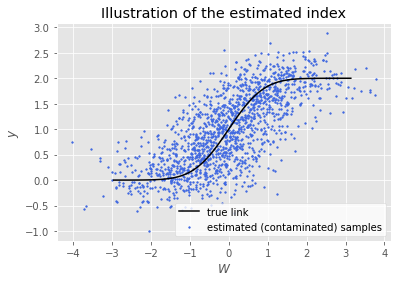

In [9]:
xx = np.linspace(min(X@beta_true),max(X@beta_true),100)
plt.plot(xx, link(xx), label="true link", color="black");
plt.scatter(W, y, label="estimated (contaminated) samples", color="RoyalBlue", s=3);
plt.legend(facecolor="white"); plt.title("Illustration of the estimated index"); 
plt.xlabel(r"$W$"); plt.ylabel("$y$");

This demonstrates that the corrected index estimate $W$ involves Gaussian error (thus we can observe perturbations along x-axis).

## Link estimation 

In [10]:
# link estimation
x = np.linspace(np.percentile(W,1),np.percentile(W,99),100)
h = 0.23
pred1 = NW(x,W,y,h,sigma_hat2/a_hat2)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.95it/s]


In [11]:
# rearangement (monotoniaztion)
pred2 = rearrangement(x,pred1,len(x))

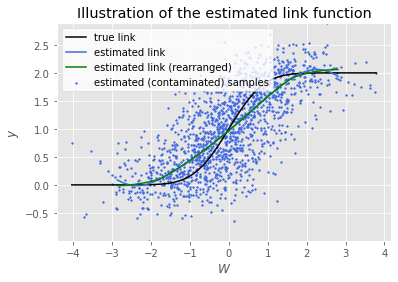

In [12]:
xx_ = np.linspace(min(W),max(W),100)
plt.plot(xx_, link(xx_), label="true link", color="black");
plt.plot(x, pred1, label="estimated link", color="RoyalBlue");
plt.plot(x, pred2, label="estimated link (rearranged)", color="green");
plt.scatter(W, y, label="estimated (contaminated) samples", color="RoyalBlue", s=3);
plt.legend(facecolor="white"); plt.title("Illustration of the estimated link function"); 
plt.xlabel(r"$W$"); plt.ylabel("$y$"); plt.ylim(min(y),max(y));

100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:01<00:00, 2298.47it/s]


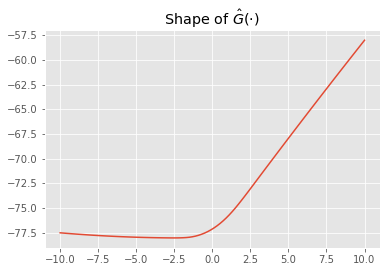

In [13]:
# linear extrapolation
left_slope, right_slope = (pred2[1]-pred2[0])/(x[1]-x[0]), (pred2[-1]-pred2[-2])/(x[-1]-x[-2])
x_, _x = -100, 100
left_intercept, right_intercept = pred2[1] - left_slope*x[1], pred2[-1]-right_slope*x[-1]
left_y, right_y = left_slope*x_+left_intercept, right_slope*_x+left_intercept
def ghat(t):
    return np.interp(t,np.append(x_,np.append(x,_x)),np.append(left_y,np.append(pred2,right_y)))

# construction of Ghat (s.t. Ghat'=ghat)
grid = np.arange(x_,_x,0.05)
Gx = np.zeros(len(grid))
for i in tqdm.tqdm(range(len(grid))):
    Gx[i] = sum(ghat(grid[:i]))*0.05
def Ghat(t):
    return np.interp(t,grid,Gx)
def ghat_prime(t):
    return (ghat(t)-ghat(t-0.000001))/0.000001
plt.plot(np.linspace(-10,10,100),Ghat(np.linspace(-10,10,100)));plt.title(r"Shape of $\hat{G}(\cdot)$");

## Final step estimation for the coefficient

In [14]:
%%time
def loss(b,xx,yy):
    return (sum(Ghat(xx@b)) - yy@(xx@b))/n
buf = minimize(loss, np.zeros(p), method='L-BFGS-B', args=(X,y))
beta_hat = buf.x

Wall time: 1.8 s


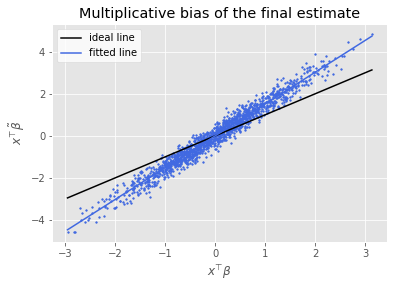

In [15]:
xx = np.linspace(min(X@beta_true),max(X@beta_true),100)
plt.plot(xx, xx, label="ideal line", color="black");
plt.scatter(X@beta_true, X@beta_hat,  color="RoyalBlue", s=3);
plt.plot(xx, xx*(beta_true@beta_hat), label="fitted line", color="RoyalBlue");
plt.legend(facecolor="white"); plt.title("Multiplicative bias of the final estimate"); 
plt.xlabel(r"$x^\top\beta$"); plt.ylabel(r"$x^\top\tilde\beta$");

In [16]:
# observable adjustment
D = np.diag(ghat_prime(X@beta_hat))
v_hat = np.trace(D-D@X@np.linalg.inv(X.T@D@X)@X.T@D)/n
r_hat2 = (y-ghat(X@beta_hat))@(y-ghat(X@beta_hat))/n
sigma_hat2 = p/n*r_hat2/v_hat**2
a_hat2 = (X@beta_hat)@(X@beta_hat)/n -(1-p/n)*sigma_hat2
T = np.sqrt(p)*(beta_hat-np.sqrt(a_hat2)*beta_true)/np.sqrt(sigma_hat2)

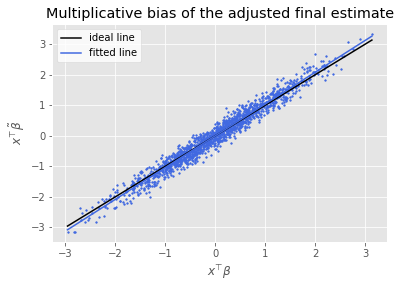

In [17]:
xx = np.linspace(min(X@beta_true),max(X@beta_true),100)
plt.plot(xx, xx, label="ideal line", color="black");
plt.scatter(X@beta_true, X@beta_hat/np.sqrt(a_hat2),  color="RoyalBlue", s=3);
plt.plot(xx, xx*(beta_true@beta_hat/np.sqrt(a_hat2)), label="fitted line", color="RoyalBlue");
plt.legend(facecolor="white"); plt.title("Multiplicative bias of the adjusted final estimate"); 
plt.xlabel(r"$x^\top\beta$"); plt.ylabel(r"$x^\top\tilde\beta$");

We can see that the variance of $x^\top\hat\beta$ is fairly smaller than that of $x^\top\tilde\beta$. This indicates the estimation by $\hat\beta$ is more precise compared to the initial estimation.

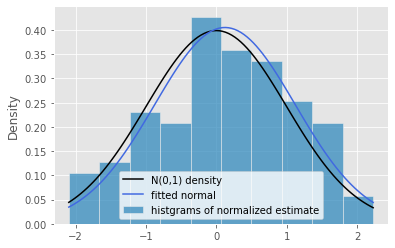

In [18]:
sns.histplot(T, stat="density", label="histgrams of normalized estimate");
x_ = np.linspace(min(T),max(T),100)
plt.plot(x_,np.exp(-x_**2/2)/np.sqrt(2*np.pi), color="black", label="N(0,1) density");
plt.plot(x_,np.exp(-(x_-np.mean(T))**2/2)/np.sqrt(2*np.pi*np.var(T)), color="RoyalBlue", label="fitted normal");
plt.legend(facecolor="white");

The statistics $T$ approximately follow normal distribution.